##### Library Import

In [28]:
import os
import pandas as pd
import numpy as np
import math
import missingno as msno
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
##setting working directory
os.chdir('C:/Users/Jeric/OneDrive/Desktop/Personal Projects/NYC_restaurants')

In [3]:
nyc = pd.read_csv("C:/Users/Jeric/OneDrive/Desktop/Personal Projects/NYC_restaurants/food_order.csv")

# Preliminary look at data

In [4]:
nyc.head()

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24


In [5]:
#data dimensions
row = len(nyc.axes[0])
column = len(nyc.axes[1])
print("Number of columns: ",column,",and number of rows: ",row)


Number of columns:  9 ,and number of rows:  1898


In [6]:
#nyc.iloc[:, [2,3,5,6]] = nyc.iloc[:, [2,3,5,6]].astype('category')

In [7]:
nyc.dtypes

order_id                   int64
customer_id                int64
restaurant_name           object
cuisine_type              object
cost_of_the_order        float64
day_of_the_week           object
rating                    object
food_preparation_time      int64
delivery_time              int64
dtype: object

Categorical variables: restaurant name, cuisine type, rating (ordinal)

Numerical: cost of order, food preparation, delivery time

In [8]:
rating_distribution = nyc.groupby("rating").size().sort_values(ascending=False)
print(rating_distribution)

rating
Not given    736
5            588
4            386
3            188
dtype: int64


There are 736 orders that do not have a rating which is approximately 38.78% of the data set, making it difficult to ignore and simply delete. 

### Why the empty ratings?
A quote from Himanshu Khanna, CEO of Sparklin, states that "Personality, mood, environment, urgency of the requirement, and eventual gratification all weigh in on how a user rates something". Usually it is strong feelings that spur customers to give feedback. A customer having a standard experience may not neccesarily find leaving a review worth the effort.

### Solution?
It is possible to assume that the missing data can be categorized as missing at random (MAR) which means that the reason that people do not give a rating may be related to other variables within the data. A possible solution would then be to either only observe the data with ratings or to impute the missing data. For this notebook, The missing data will be imputed and observed then compared to the unmodified data in terms of visualization.

In [9]:
#replace "Not Given" with NA
nyc_imp = nyc.copy()
nyc_imp['rating_imp'] = nyc_imp['rating']
nyc_imp['rating_imp'] = nyc_imp['rating_imp'].replace('Not given', np.nan)

In [10]:
nyc_imp.head()

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time,rating_imp
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20,NaN
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23,NaN
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28,5
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15,3
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24,4


In [12]:
#mean imputation where the missings are replaced with the mean of the ratings
mean_imputer = SimpleImputer(strategy='mean')
nyc_imp['rating_imp'] = mean_imputer.fit_transform(nyc_imp['rating_imp'].values.reshape(-1,1))
nyc_imp.head()

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time,rating_imp
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20,4.344234
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23,4.344234
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28,5.000000
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15,3.000000
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24,4.000000


In [26]:
rating_distribution2 = nyc_imp.groupby("rating_imp").size().sort_values(ascending=False)
print(rating_distribution2)

rating_imp
4.344234    736
5.000000    588
4.000000    386
3.000000    188
dtype: int64


The 'Not given' records have now been replaced with the mean rating which is 4.34 which allows us to make use of the previously missing data and give us insight closer to reality than if we were to simply cut out the data.

In [13]:
#find summary statistics
print(nyc_imp.loc[:,~nyc_imp.columns.isin(['order_id','customer_id'])].describe().round(2))

       cost_of_the_order  food_preparation_time  delivery_time  rating_imp
count            1898.00                1898.00        1898.00     1898.00
mean               16.50                  27.37          24.16        4.34
std                 7.48                   4.63           4.97        0.58
min                 4.47                  20.00          15.00        3.00
25%                12.08                  23.00          20.00        4.00
50%                14.14                  27.00          25.00        4.34
75%                22.30                  31.00          28.00        5.00
max                35.41                  35.00          33.00        5.00


Table of cuisine types

In [14]:
#limit the display rows to 20 for readability
pd.options.display.max_rows = 20

In [15]:
cuisine_type = nyc_imp.groupby(["cuisine_type"]).size().sort_values(ascending=False)
print(cuisine_type.head(10))

cuisine_type
American          584
Japanese          470
Italian           298
Chinese           215
Mexican            77
Indian             73
Middle Eastern     49
Mediterranean      46
Thai               19
French             18
dtype: int64


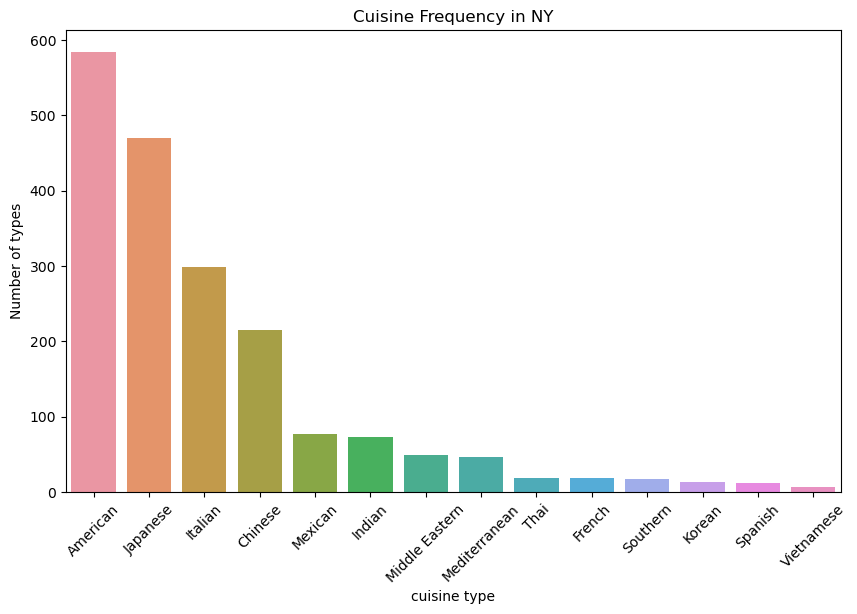

In [30]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x = cuisine_type.index, y = cuisine_type.values)
plt.xlabel("cuisine type")
plt.ylabel("Number of types")
plt.title("Cuisine Frequency in NY")
plt.xticks(rotation=45)
plt.show()

Visualized, we can see that the most ordered cuisine type in New York is American followed by Japanese and then Italian.

In [16]:
avgprice_cuisine = nyc_imp.groupby("cuisine_type")["cost_of_the_order"].mean().sort_values(ascending=False)
display(avgprice_cuisine)

cuisine_type
French            19.793889
Southern          19.300588
Thai              19.207895
Spanish           18.994167
Middle Eastern    18.820612
Mexican           16.933117
Indian            16.919726
Italian           16.418691
American          16.319829
Chinese           16.305209
Japanese          16.304532
Mediterranean     15.474783
Korean            14.001538
Vietnamese        12.882857
Name: cost_of_the_order, dtype: float64

In [17]:
avgprep_cuisine = nyc.groupby("cuisine_type")["food_preparation_time"].mean().sort_values(ascending=False)
display(avgprep_cuisine)

cuisine_type
Southern          27.588235
Chinese           27.511628
Japanese          27.510638
Italian           27.483221
American          27.440068
Thai              27.315789
Indian            27.109589
Mediterranean     27.000000
Spanish           26.916667
French            26.888889
Mexican           26.727273
Middle Eastern    26.673469
Vietnamese        25.714286
Korean            25.461538
Name: food_preparation_time, dtype: float64

In [18]:
most_popular_restaurants = nyc_imp.groupby(["restaurant_name"]).size().sort_values(ascending=False)
print(most_popular_restaurants.head(10))

restaurant_name
Shake Shack                      219
The Meatball Shop                132
Blue Ribbon Sushi                119
Blue Ribbon Fried Chicken         96
Parm                              68
RedFarm Broadway                  59
RedFarm Hudson                    55
TAO                               49
Han Dynasty                       46
Blue Ribbon Sushi Bar & Grill     44
dtype: int64


In [19]:
#when are there most orders?
day_of_orders = nyc_imp.groupby(["day_of_the_week"]).size().sort_values(ascending=False)
print(day_of_orders.head(10)) #mostly during the weekend

day_of_the_week
Weekend    1351
Weekday     547
dtype: int64


In [20]:
#How long on average is the time between ordering food and receiving it?
nyc_imp['prep+del'] = nyc_imp['food_preparation_time'] + nyc_imp['delivery_time']
nyc_imp.head()

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time,rating_imp,prep+del
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20,4.344234,45
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23,4.344234,48
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28,5.000000,51
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15,3.000000,40
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24,4.000000,49


In [21]:
avg_duration_cuisine = nyc_imp.groupby("cuisine_type")["prep+del"].mean().sort_values(ascending=False)
display(avg_duration_cuisine)

cuisine_type
French            52.222222
Italian           52.050336
Vietnamese        51.857143
Japanese          51.642553
American          51.633562
Southern          51.411765
Chinese           51.367442
Indian            51.191781
Mexican           51.116883
Middle Eastern    50.755102
Mediterranean     50.586957
Thai              50.473684
Spanish           50.333333
Korean            46.384615
Name: prep+del, dtype: float64

In [22]:
#top 10 restaurants and their ratings
best_cuisine = nyc_imp.groupby("cuisine_type")["rating_imp"].mean().sort_values(ascending=False)
display(best_cuisine.head(10))

cuisine_type
Spanish     4.588784
Thai        4.496965
Indian      4.478320
Mexican     4.389387
Japanese    4.361307
Italian     4.353602
Chinese     4.340592
French      4.319660
Southern    4.316290
American    4.315676
Name: rating_imp, dtype: float64

In [23]:
nyc_imp.loc[:,~nyc_imp.columns.isin(['order_id','customer_id'])].corr()

,cost_of_the_order,food_preparation_time,delivery_time,rating_imp,prep+del
cost_of_the_order,1.000000,0.041527,-0.029949,0.026901,0.006358
food_preparation_time,0.041527,1.000000,0.011094,-0.004805,0.685970
delivery_time,-0.029949,0.011094,1.000000,-0.007606,0.735195
rating_imp,0.026901,-0.004805,-0.007606,1.000000,-0.008792
prep+del,0.006358,0.685970,0.735195,-0.008792,1.000000
